## Import library

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Import data and clean the text

In [2]:
loader = DataLoader()
d = loader.GetData('final')
d.head()

,用户ID,学号,姓名,班级,院系,任课教师,Class,Prompt,score,text
0,1003246377,21120199,古丽依娜·买买提克力木,2021-22冬季通用英语C2刘学青1005期末,法学院,1002658406(刘学青),C,19121438,9.0,...
1,1003248323,21122145,王名振,2021-22冬季通用英语B2谢怡沁1014期末,通信与信息工程学院,1002658415(谢怡沁),B,19121435,9.6,"As a person, the people around us are always c..."
2,1003249593,21123420,周祺,2021-22冬季通用英语C2刘学青1016期末,上海美术学院,1002658406(刘学青),C,19121440,8.7,"Since we are little, we have been told to read..."
3,1003250643,21124470,张芷昕,2021-22冬季通用学术英语A2张新玲1008期末,音乐学院,1002658431(张新玲),A,1000561535,11.1,"With the development of networks, Internet i..."
4,1003246209,21120031,晏三,2021-22冬季通用英语B2谢怡沁1014期末,法学院,1002658415(谢怡沁),B,19121437,10.5,"As we all know, friendship is essential for th..."


In [63]:
clean_text = []
preproc = preprocessing.make_pipeline(preprocessing.normalize.whitespace)
for essay in d['text']:
    cleaned = preproc(essay.replace("'s", "'s '").replace('\n',''))
    clean_text.append(cleaned)
d['text'] = clean_text

C:\Users\GIGA\AppData\Local\Temp\ipykernel_1860\455372124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['text'] = clean_text


### Load similarity matrices

In [4]:
f = np.load('features/final_winter_sent.npz')

In [5]:
sim_list = [f[a] for a in f.files]

## Get mean, max and min values of sim matrices

In [48]:
sim_raw_list = []
for n in f.files:
    values = []
    m = f[n]
    for row in range(len(m)):
        for col in range(row+1,len(m)):
            values.append(m[row,col])
    sim_raw_list.append(np.array(values))

In [49]:
sim_mean = []
sim_max = []
sim_min = []
sim_var = []
sim_corr_mean = []
for matrix in sim_raw_list:
    if len(matrix) > 1:
        sim_mean.append(np.average(matrix))
        sim_max.append(np.max(matrix))
        sim_min.append(np.min(matrix))
        sim_var.append(np.var(matrix))
        avg = []
        for i in range(len(matrix) // 10):
            avg.append(np.average(matrix[i*10:i*10+10]))
        sim_corr_mean.append(np.average(avg))
    else:
        sim_mean.append(0)
        sim_max.append(0)
        sim_min.append(0)
        sim_corr_mean.append(0)
        sim_var.append(0)

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Get cluster data

In [8]:
cluster_num = []
bigram_sim = []
cluster_avg = []
row1_sim = []
for k in range(len(sim_list)):
    sim = sim_list[k]
    if len(sim) > 1:
        sim_thres = sim.copy()
        for i in range(len(sim_thres)):
            for j in range(len(sim_thres)):
                if sim_thres[i,j] <= np.percentile(np.array(sim_raw_list[k]),50):
                    sim_thres[i,j] = 0
        res = mcl.run_mcl(sim_thres,inflation=2)
        clusters = mcl.get_clusters(res)
        cluster_num.append(len(clusters))
        cluster_avg.append(len(sim)/len(clusters))
        bigram = []
        for i in range(len(sim)-1):
            bigram.append(sim[i,i+1])
        bigram_sim.append(np.average(np.array(bigram)))
        row1_sim.append(np.average(sim[0,1:]))
    else:
        cluster_num.append(0)
        bigram_sim.append(0)
        row1_sim.append(0)
        cluster_avg.append(0)

### Add data to dataframe

In [50]:
d = loader.GetData('final')
d['mean'] = sim_mean
d['max'] = sim_max
d['min'] = sim_min
d['cluster_num'] = cluster_num
d['bigram_sim'] = bigram_sim
d['row1_sim'] = row1_sim
d['cluster_avg'] = cluster_avg        
d['corr_mean'] = sim_corr_mean  
d['variance'] = sim_var                                            

### Select non-zero scores, and add level percentile

In [52]:
d = d.loc[d['score'] > 0]
d.loc[:,'level'] = 0
percentiles = []
for i in range(10,100,10):
    percentiles.append(np.percentile(d['score'],i))
d.loc[d['score'] <= percentiles[0],'level'] = '100'
for i in range(8):
    d.loc[(d['score'] <= percentiles[i+1]) & (d['score'] > percentiles[i]),'level'] = str((10-i-1)*10)
d.loc[d['score'] > percentiles[-1],'level'] = '10'

C:\Users\GIGA\AppData\Local\Temp\ipykernel_1860\4113198267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.loc[:,'level'] = 0


## Linear regression

In [53]:
model = pg.linear_regression(d[['mean','min','max','cluster_num','cluster_avg']],d['score'],relimp=True,remove_na=True)
model

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,7.876418,0.163459,48.185781,0.000000e+00,0.176768,0.175678,7.555941,8.196895,NaN,NaN
1,mean,-2.398297,1.004458,-2.387652,1.700524e-02,0.176768,0.175678,-4.367629,-0.428964,0.018793,10.631541
2,min,-7.579168,1.271904,-5.958915,2.771471e-09,0.176768,0.175678,-10.072852,-5.085483,0.025913,14.659388
3,max,-0.256649,0.208316,-1.232014,2.180206e-01,0.176768,0.175678,-0.665072,0.151775,0.002520,1.425515
4,cluster_num,0.392581,0.017606,22.297735,1.421879e-103,0.176768,0.175678,0.358062,0.427100,0.103302,58.439415
5,cluster_avg,0.348954,0.023553,14.815876,2.563340e-48,0.176768,0.175678,0.302777,0.395131,0.026240,14.844141


In [82]:
for i in model['coef']:
    print('{:.2f}'.format(i))

7.88
-2.31
-7.92
-0.23
0.39
0.35


## Logistic regression

In [54]:
model = sm.MNLogit(d['Class'],d[['mean','min','max','cluster_num','cluster_avg']])
model_res = model.fit()
model_res.summary()

Optimization terminated successfully.
         Current function value: 1.187621
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                  Class   No. Observations:                 3784
Model:                        MNLogit   Df Residuals:                     3769
Method:                           MLE   Df Model:                           12
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                 0.02228
Time:                        22:44:45   Log-Likelihood:                -4494.0
converged:                       True   LL-Null:                       -4596.4
Covariance Type:            nonrobust   LLR p-value:                 3.344e-37
===============================================================================
    Class=B       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
mean            6.1339      2.060      2.978      0.003       2.097      10.171
min            -2.9523      3.023     -0.977      0.329      -8.876       2.972
max             0.2214      0.472      0.470      0.639      -0.703       1.146
cluster_num     0.0010      0.018      0.054      0.957      -0.034       0.036
cluster_avg    -0.0138      0.049     -0.285      0.776      -0.109       0.081
-------------------------------------------------------------------------------
    Class=C       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
mean           11.1513      2.247      4.962      0.000       6.747      15.556
min             0.4982      3.163      0.157      0.875      -5.701       6.698
max             0.3371      0.507      0.664      0.506      -0.657       1.331
cluster_num    -0.1565      0.021     -7.592      0.000      -0.197      -0.116
cluster_avg    -0.2112      0.057     -3.737      0.000      -0.322      -0.100
-------------------------------------------------------------------------------
    Class=D       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
mean           14.9584      3.522      4.247      0.000       8.056      21.861
min            -5.6501      4.652     -1.215      0.225     -14.768       3.468
max            -0.0385      0.811     -0.047      0.962      -1.628       1.551
cluster_num    -0.3901      0.036    -10.745      0.000      -0.461      -0.319
cluster_avg    -0.4543      0.097     -4.665      0.000      -0.645      -0.263
===============================================================================
"""

### Plot some results

Text(0.5, 12.44444444444443, 'Language level')

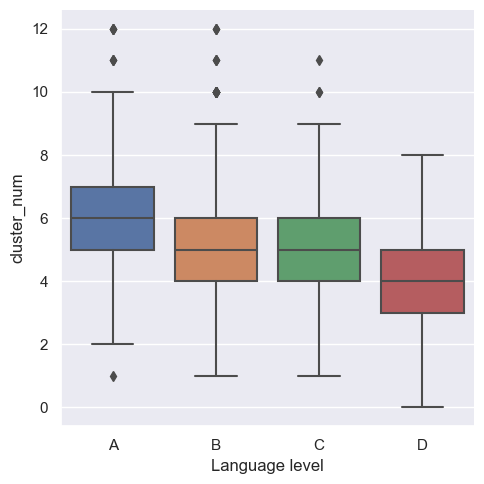

In [89]:
sns.set_theme(style='darkgrid')
sns.catplot(d,y='cluster_num',x='Class',kind='box',order=['A','B','C','D'])
#order=[str(i*10) for i in range(1,11)] ['A','B','C','D']
plt.xlabel('Language level')

In [57]:
d.loc[2888]

用户ID                                                  1003247890
学号                                                      21121712
姓名                                                            陈昊
班级                                      2021-22冬季通用英语C2张秀丽1027期末
院系                                                    机电工程与自动化学院
任课教师                                             1002658411(张秀丽)
Class                                                          C
Prompt                                                1000561535
score                                                        8.1
text               The internet addiction have many bad conse...
mean                                                    0.313303
max                                                          1.0
min                                                     0.075797
cluster_num                                                    4
bigram_sim                                              0.314517
row1_sim                 

In [166]:
#d[(d['mean']< 0.14) & (d['mean'] > 0.13) & (d['level'] == '50') & (d['Class'] == 'B')]
d[d['score'] == 13.6]

,用户ID,学号,姓名,班级,院系,任课教师,Class,Prompt,score,text,mean,max,min,cluster_num,bigram_sim,row1_sim,cluster_avg,corr_mean,variance,level
2087,1003246810,21120632,雷詩婷,2021-22冬季通用英语B2谢怡沁1027期末,经济学院,1002658415(谢怡沁),B,19121436,13.6,"In this modern day and age, most people, if no...",0.085013,0.370806,0.003703,12,0.092412,0.050703,2.166667,0.085847,0.00417,10


2888,2087,1067

In [86]:
sim = f[f.files[2888]]

In [41]:
sim_thres = sim.copy()
for i in range(len(sim_thres)):
    for j in range(len(sim_thres)):
        if sim_thres[i,j] <= np.percentile(sim_raw_list[2888],50):
            sim_thres[i,j] = 0

In [56]:
np.percentile(sim_raw_list[2888],90)

0.4916491762553151

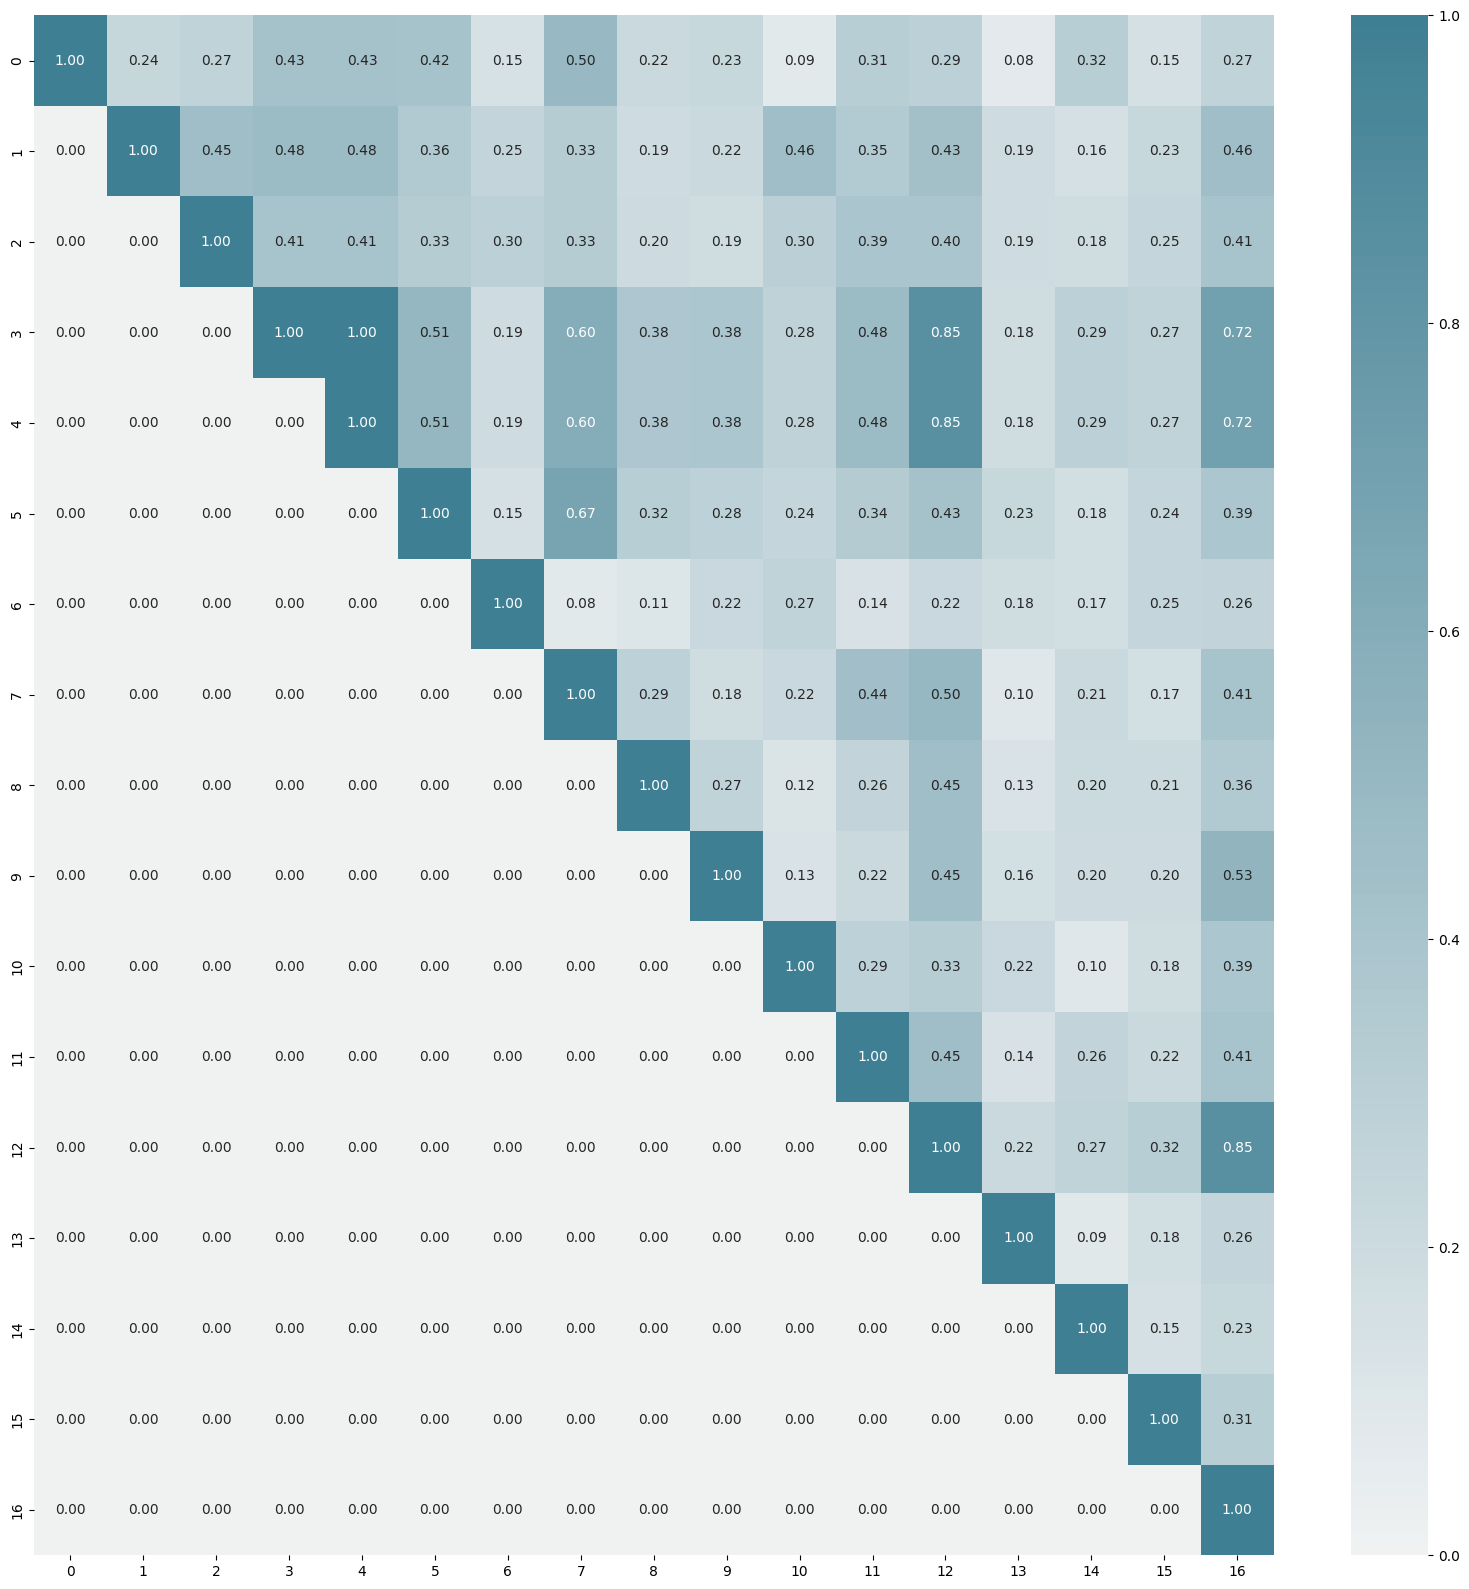

In [87]:
c = sns.diverging_palette(20, 220, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))   
g = sns.heatmap(sim,vmin=0,vmax=1,center=0,annot=True,fmt='.2f',cmap=c)

In [13]:
np.fill_diagonal(sim_thres,0)
res = mcl.run_mcl(sim_thres,inflation=2)
clusters = mcl.get_clusters(res)

In [20]:
len(clusters)

12

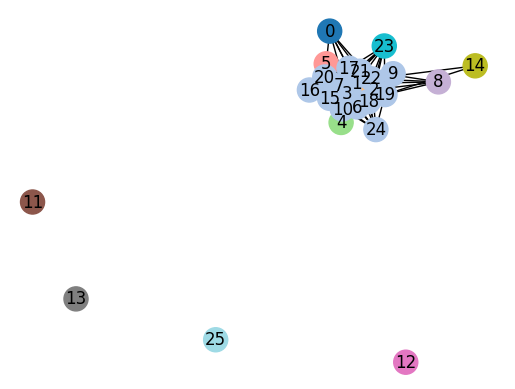

In [16]:
mcl.draw_graph(sim_thres,clusters)

In [97]:
doc = NLP(d['text'][1067])

In [99]:
for i in range(len(sents)):
    print(i,sents[i])

0 It's ' known to all that we need to read a bulk of books if we want to keep abreast of time.
1 However, many people fail to read fast, which lowers their reading efficiency.
2 As a person who enjoy reading a lot, I conclude several tips on how to improve your reading spead.
3 The tips are as follows.
4 First, don't read articles aloud or in mind.
5 There are a number of people read books with a voice in their mind without noticing.
6 It amounts that reading books aloud is a slow way of reading books, regardless of reading aloud or just in mind.
7 So we have to avoid reading books with a voice in our mind and try to understand the words in the books just with our eyes.
8 It can be done if you train yourself several times.
9 Second, use a ruler or a pencil to show which line you are reading now.
10 You can move your ruler slowly to the next line at first.
11 This can help you to keep focus on the article and know your reading speed.
12 Then try to move the ruler a little bit quicker to

In [98]:
sents = [j for j in doc.sents if len(str(j).split()) > 3]

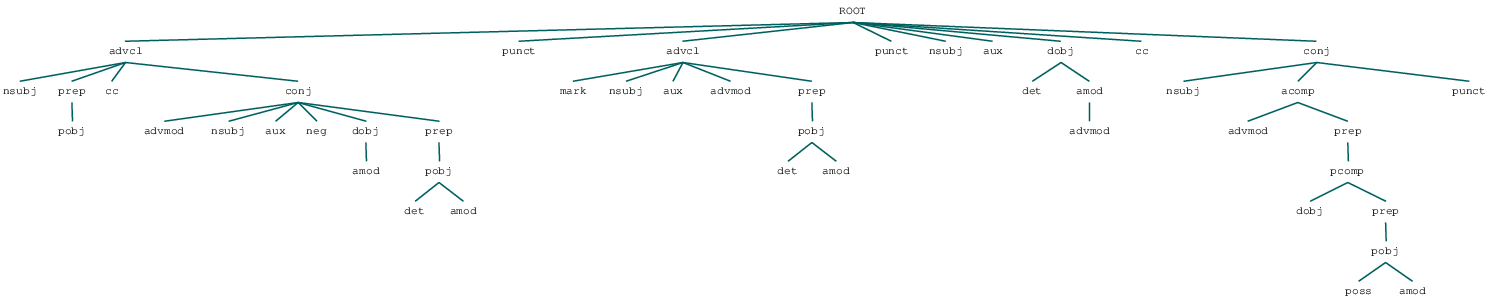

In [95]:
CreateDepTree(sents[11].root)

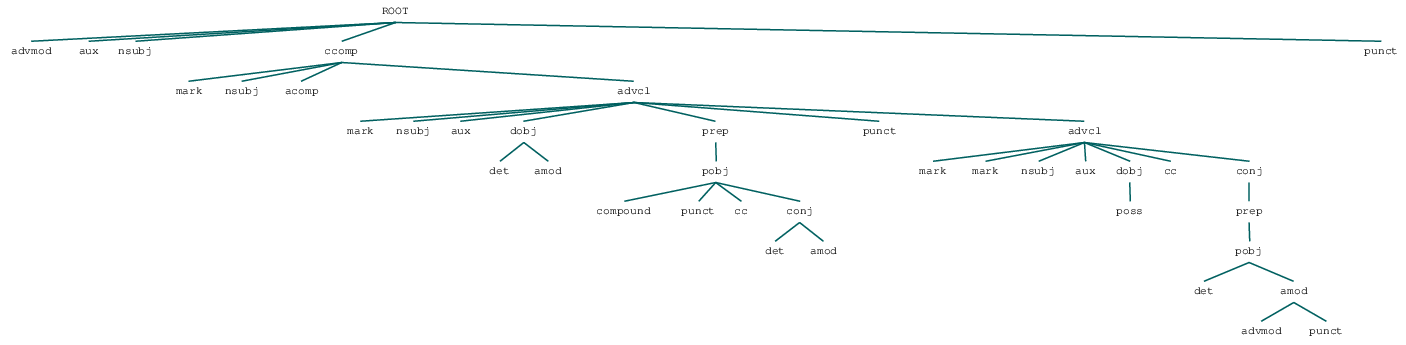

In [96]:
CreateDepTree(sents[25].root)

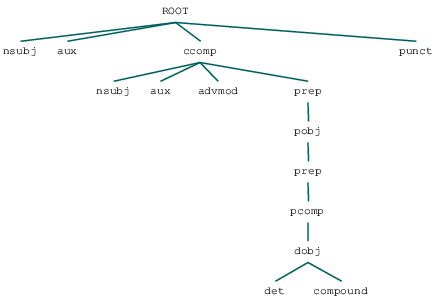

In [77]:
CreateDepTree(sents[16].root)

In [100]:
trps = []
self_sim = []
for i in range(len(sents)):
    self_sim.append(PartialTreeKernel(sents[i],sents[i]))
for i in range(len(sents)):
    for j in range(i+1,len(sents)):
        #sim_matrix[i,j] = PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_sim[i]*self_sim[j])
        trps.append((sents[i],sents[j],PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_sim[i]*self_sim[j])))
sorted(trps,key=lambda x:x[2],reverse=True)

[(This can help you to keep focus on the article and know your reading speed.,
  You will find you can read fast by virtue of having no speed markers.,
  0.34862053151765227),
 (After that, you can try to read without a speed marker.,
  You will find you can read fast by virtue of having no speed markers.,
  0.3117936344524934),
 (You will find you can read fast by virtue of having no speed markers.,
  I really hope that my advice can help you.,
  0.30424950813694485),
 (Finally, you will find your reading speed is quicker a lot.,
  I really hope that my advice can help you.,
  0.2939399279545463),
 (First, don't read articles aloud or in mind.,
  Last but not least, improving reading speed doesn't mean read fast at anytime.,
  0.2917615591640047),
 (This can help you to keep focus on the article and know your reading speed.,
  I really hope that my advice can help you.,
  0.2756602964946008),
 (You will find you can read fast by virtue of having no speed markers.,
  These are my tips 